In [30]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

The below is taken from http://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/

In [31]:
from mlxtend.data import loadlocal_mnist
X_test, Y_test = loadlocal_mnist(
            images_path='/content/drive/MyDrive/MIDAS SI Task/t10k-images.idx3-ubyte', 
            labels_path='/content/drive/MyDrive/MIDAS SI Task/t10k-labels.idx1-ubyte')
X_train, Y_train = loadlocal_mnist(
            images_path='/content/drive/MyDrive/MIDAS SI Task/train-images.idx3-ubyte', 
            labels_path='/content/drive/MyDrive/MIDAS SI Task/train-labels.idx1-ubyte')

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

import tensorflow as tf
tf.device('GPU:0')

In [33]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

In [34]:
X_train = X_train/255 #Normalise for faster training.
X_test = X_test/255
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

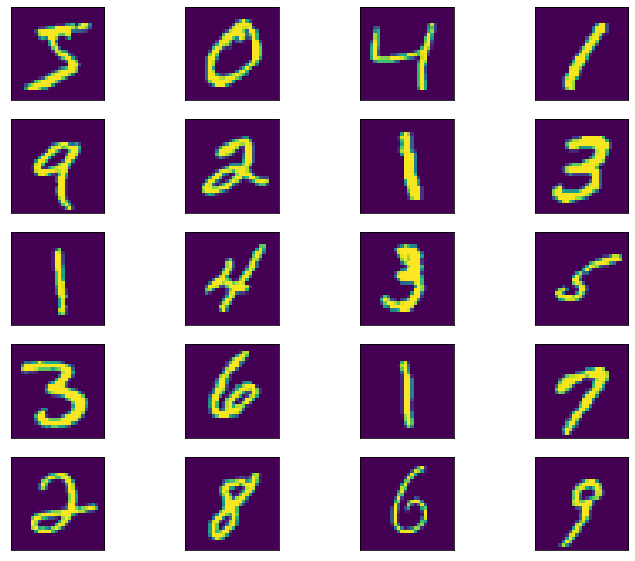

In [35]:
plt.figure(figsize=(12, 10))
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i][:,:,0])

In [36]:
Y_train = pd.get_dummies(Y_train)
Y_test = pd.get_dummies(Y_test)

In [37]:
Y_train

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,1,0
59996,0,0,0,1,0,0,0,0,0,0
59997,0,0,0,0,0,1,0,0,0,0
59998,0,0,0,0,0,0,1,0,0,0


In [38]:
model = Sequential()
model.add(Conv2D(50, (3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(100, (3,3), activation='relu', padding='same'))
model.add(Conv2D(200, (3,3), activation='relu', padding='same'))
model.add(Conv2D(400,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Conv2D(800, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(10, activation='softmax'))

In [39]:
model.compile(
    optimizer = 'adam', loss = 'categorical_crossentropy', metrics=(['accuracy'])
)

early_stopping = EarlyStopping(
    monitor = 'val_loss', patience = 10, restore_best_weights = True
)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

model_checkpoint = ModelCheckpoint(
    'MNIST_Random_Weights.hdf5', monitor = 'val_loss', save_best_only=True
)

In [40]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [41]:
epochs = 3
batch_size=100

In [46]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,Y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,early_stopping, model_checkpoint])

Epoch 1/3
600/600 - 2324s - loss: 0.5642 - accuracy: 0.8434 - val_loss: 0.0925 - val_accuracy: 0.9754
Epoch 2/3
600/600 - 2329s - loss: 0.1160 - accuracy: 0.9683 - val_loss: 0.0388 - val_accuracy: 0.9876
Epoch 3/3
600/600 - 2318s - loss: 0.0978 - accuracy: 0.9742 - val_loss: 0.0892 - val_accuracy: 0.9757


In [42]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    plt.figsize=(10, 10)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    plt.figsize=(10, 10)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

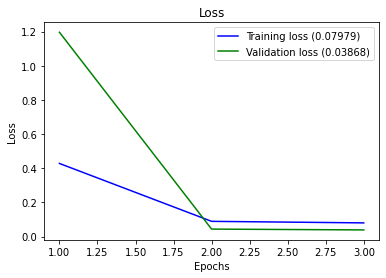

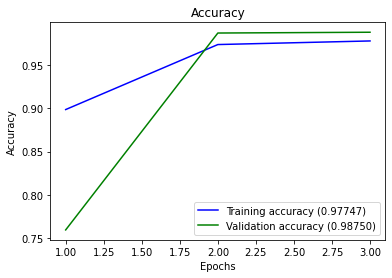

In [43]:
plot_history(history)